### НИЯУ МИФИ. Лаботаторная работа #1. Полищук Максим, Б20-505

# Используемая система

```
CPU: 6-core 12th Gen Intel Core i5-12400F (-MCP-) speed: 2496 MHz
Kernel: 5.15.0-50-generic x86_64 Up: 45m Mem: 3491.6/9937.1 MiB (35.1%)
Storage: 71.31 GiB (20.1% used) Procs: 292 Shell: Zsh inxi: 3.3.13

```

**Сложность алгоритма - O(n/p)**

n - количество элементов массива

p - количество потоков

```mermaid
    graph TD
        %%{ init : {"flowchart" : { "curve" : "stepAfter", "diagramPadding": 20 }}}%%
        A(Начало) --> B(i: 0 -> n)
        
        B --> C{"array[i] > max"}
        B --> E(Выход)
        C -->|Да| D["max = array[i]"]
        C -->|Нет| B
        D --> B
       
```

# Код
```
#include <stdio.h>
#include <stdlib.h>
#include <omp.h>

#define MROWS 100
#define CORE_LIMIT 6

int main(int argc, char** argv)
{
    const int count = 10000000;     ///< Number of array elements
    const int random_seed = 31337; ///< RNG seed

    int** matrix = 0;              ///< The array we need to find the max in
    int  max = -1;                ///< The maximal element
    double start, end;

    srand(random_seed);

    /* Generate the random MATRIX */
    matrix = (int**)calloc(MROWS, sizeof(int*));
    for (int i = 0; i < MROWS; i++) {
        matrix[i] = (int*)calloc(count, sizeof(int));
    }
    for (int i = 0; i < MROWS; i++) {
        for (int elem = 0; elem < count; elem++) {
            matrix[i][elem] = rand();
        }
    }
    char filename[50];
    sprintf(filename, "trace.txt");
    FILE *fp = fopen(filename, "w");
    if (fp == NULL) {
        printf("Can't open file\n");
        exit(1);
    }
    for (int thread = 1; thread <= CORE_LIMIT; thread++) {
        for (int row = 0; row < MROWS; row++) {
            max = -1;
            start = omp_get_wtime();
            #pragma omp parallel num_threads(thread) shared(matrix, count, row) reduction(max: max) default(none)
            {
                #pragma omp for
                for(int i=0; i<count; i++)
                {
                    if(matrix[row][i] > max) { 
                        max = matrix[row][i]; 
                    };
                }
            }
            end = omp_get_wtime();
            printf("CURR_THREAD = %d\n", thread);
            fprintf(fp, "%f;", end-start);
            
        }
        fprintf(fp, "\n");
    }
    fclose(fp);
    printf("Exit...\n");
    return(0);
}
```

In [7]:
# import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set_theme(style="darkgrid")

dataset = []
with open("trace.txt", "r") as f:
    for _ in range(12):
        line = list(map(float, f.readline().split(";")))
        dataset.append(line)
        
for i in range(len(dataset)):
    line = dataset[i]
    line.sort()
    line = line[10:-10]
    dataset[i] = line

In [8]:

data = []
for i, line in enumerate(dataset):
    data.append([i+1, (sum(line)/len(line))*1000, "Real"])
saved = data.copy()
data1 = data
data_df = pd.DataFrame(data, columns=["Threads", "AvgTime", "Type"])
for i in range(1, len(data1)): 
    data1[i] = [data1[i][0], data1[0][1] / data1[i][0], "Perfect"]
data1[0][2] = "Perfect"
# pdf = pd.DataFrame(data1, columns=["Threads", "AvgTime"])
data1 = pd.DataFrame(data1, columns=["Threads", "AvgTime", "Type"])
all_data = pd.concat([data1, data_df])

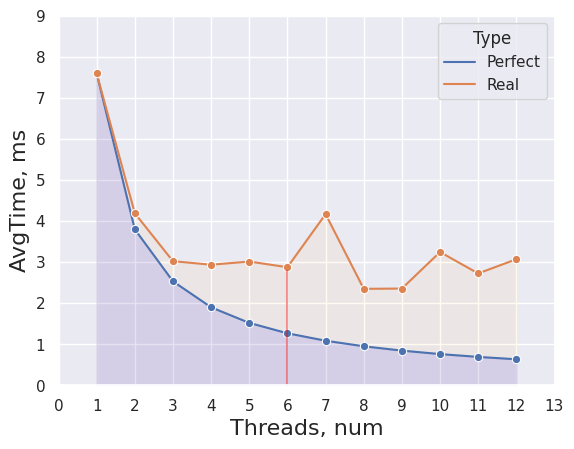

In [39]:
p = sns.lineplot(x="Threads", y="AvgTime", hue="Type", marker="o", data=all_data)
p.set_xlabel("Threads, num", fontsize = 16)
p.set_ylabel("AvgTime, ms", fontsize = 16)
l1 = p.lines[0]

x1 = l1.get_xydata()[:, 0]
y1 = l1.get_xydata()[:, 1]

p.fill_between(x1, y1, color="blue", alpha=0.1)
l2 = p.lines[1]

x2 = l2.get_xydata()[:, 0]
y2 = l2.get_xydata()[:, 1]

p.fill_between(x2, y2, color="orange", alpha=0.05)
p.margins(x=0, y=0)
_ = p.set_xticks(range(0, 14))
_ = p.set_xticklabels([str(i) for i in range(0, 14)])
_ = p.set_yticks(range(0, 10))
_ = p.set_yticklabels(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
_ = p.axvline(x=6, ymax=0.31, color="red", alpha=0.4)

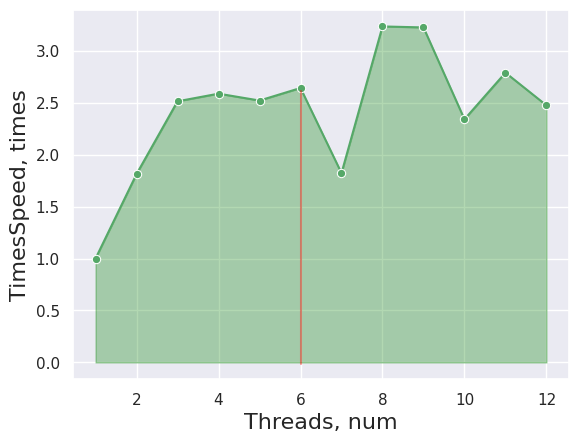

In [54]:
accceleration = [0] * 12
for i in range(0, len(accceleration)):
    accceleration[i] = [saved[i][0], saved[0][1]/saved[i][1]]
a_df = pd.DataFrame(accceleration, columns=["Threads", "TimesSpeed"])
p = sns.lineplot(x="Threads", y="TimesSpeed", marker="o", data=a_df, color='g')
p.set_xlabel("Threads, num", fontsize = 16)
p.set_ylabel("TimesSpeed, times", fontsize = 16)
l1 = p.lines[0]

x1 = l1.get_xydata()[:, 0]
y1 = l1.get_xydata()[:, 1]

_ = p.fill_between(x1, y1, color="green", alpha=0.3)
_ = p.axvline(x=6, ymin=0.04, ymax=0.78, color="red", alpha=0.4)

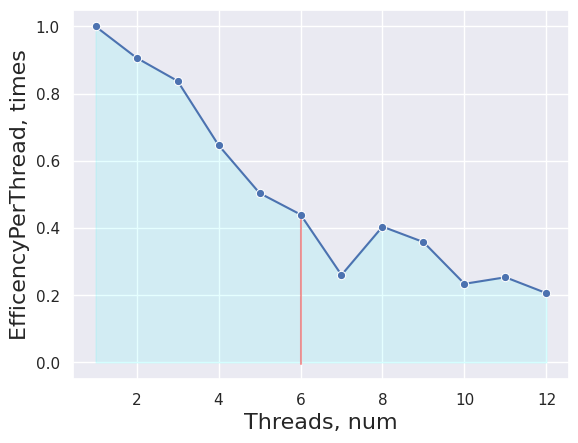

In [58]:
per_thread = [0] * 12
for i in range(0, len(per_thread)):
    per_thread[i] = [accceleration[i][0], accceleration[i][1]/accceleration[i][0]]
thr_df = pd.DataFrame(per_thread, columns=["Threads", "EfficencyPerThread"])
p = sns.lineplot(x="Threads", y="EfficencyPerThread", marker="o", data=thr_df, color='b')
p.set_xlabel("Threads, num", fontsize = 16)
p.set_ylabel("EfficencyPerThread, times", fontsize = 16)
l1 = p.lines[0]

x1 = l1.get_xydata()[:, 0]
y1 = l1.get_xydata()[:, 1]

_ = p.fill_between(x1, y1, color="cyan", alpha=0.1)
_ = p.axvline(x=6, ymin=0.04, ymax=0.43, color="red", alpha=0.4)

## Заключение

В этой работе с использованием **OpenMP** в языке программирования **C** было проведено исследование эффективности многопоточности алгоритма поиска максимального элемента массива.
На машине было 6 реальных ядер, которые задествовала программа, а последующие являются виртуальными

**Вывод:**
- Реальный прирост от количества потоков далёк от рассчётного
- Эффектиность виртальных потоков сильно падает по сравнению с реальными => целесообразность их использования под сомнением.